In [1]:
# From https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/context_encoder/context_encoder.py

import glob
import random
import os
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.jpg" % root))
        self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)


In [2]:
# Models, also from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/context_encoder/context_encoder.py

import torch.nn as nn
import torch.nn.functional as F
import torch

# MultiGenerator just adds a classifier head to the generator.
class MultiGenerator(nn.Module):
    def __init__(self, channels=3, num_classes = 10):
        super(MultiGenerator, self).__init__()
        
        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers
        self.layer1 = self.downsample(channels, 64, normalize=False)
        self.layer2 = self.downsample(64, 64)
        self.layer3 = self.downsample(64, 128)
        self.layer4 = self.downsample(128, 256)
        self.layer5 = self.downsample(256, 512)
        self.gen = nn.Sequential(
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )
        self.classifier_head = nn.Sequential(nn.Dropout(), nn.Linear(512,num_classes))
        #self.linear = nn.Linear(512, num_classes)
        
    def downsample(self, in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        classifier = out.view(out.size(0),-1)
        classifier = self.classifier_head(classifier)
        generator = self.gen(out)
        return classifier, generator

# TODO: Make this fit into preact resnet base? GAN with resnet blocks?
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [3]:
# Getting this to work with cifar10
import torchvision
import torchvision.transforms as transforms 


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
def remake_dataloaders(batch_size, test_batch_size=12):
    dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                             shuffle=False, num_workers=2)
    return dataloader, testloader
dataloader, testloader = remake_dataloaders(batch_size)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Attempt at Robust SSL, from https://github.com/locuslab/robust_overfitting

"""
Inpainting using Generative Adversarial Networks.
The dataset can be downloaded from: https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADIKlz8PR9zr6Y20qbkunrba/Img/img_align_celeba.zip?dl=0
(if not available there see if options are listed at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
Instrustion on running the script:
1. Download the dataset from the provided link
2. Save the folder 'img_align_celeba' to '../../data/'
4. Run the sript using command 'python3 context_encoder.py'
"""

import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

#from datasets import *
#from models import *

import torch.nn as nn
import torch.nn.functional as F
import torch

# Some arguments are old & irrelevant

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=8, help="size of the batches")
parser.add_argument("--dataset_name", type=str, default="img_align_celeba", help="name of the dataset")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=4, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--mask_size", type=int, default=16, help="size of random mask")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=500, help="interval between image sampling")
opt, unknown = parser.parse_known_args()

print(opt)

cuda = True if torch.cuda.is_available() else False

# Calculate output of image discriminator (PatchGAN)
patch_h, patch_w = int(opt.mask_size / 2 ** 3), int(opt.mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = MultiGenerator(channels=opt.channels)
only_generator = Generator(channels=opt.channels)
discriminator = Discriminator(channels=opt.channels)

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()
    ce_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_C = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2)) # Unsure if there's any use for this
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Namespace(b1=0.5, b2=0.999, batch_size=8, channels=3, dataset_name='img_align_celeba', img_size=32, latent_dim=100, lr=0.0002, mask_size=16, n_cpu=4, n_epochs=200, sample_interval=500)


In [15]:
generator.load_state_dict(torch.load('new_multigen.pth'))
discriminator.load_state_dict(torch.load('new_disc.pth'))

<All keys matched successfully>

In [12]:
img_size = 32
mask_size = 16

def apply_center_mask(img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (img_size - mask_size) // 2
        masked_img = img.clone()
        masked_img[:, :, i : i + mask_size, i : i + mask_size] = 1

        return masked_img, i
    
samples, _ = next(iter(testloader))
masked_samples, i = apply_center_mask(samples)
samples = Variable(samples.type(Tensor))
masked_samples = Variable(masked_samples.type(Tensor))
#i = i[0].item()  # Upper-left coordinate of mask
# Generate inpainted image
generator.eval()
with torch.no_grad():
    _, gen_mask = generator(masked_samples)
filled_samples = masked_samples.clone()
# Place the generated mask into the image
filled_samples[:, :, i : i + opt.mask_size, i : i + opt.mask_size] = gen_mask
# Save sample
sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)

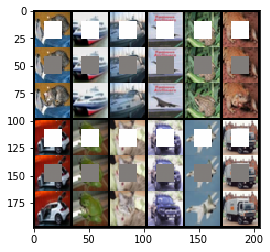

In [13]:
# Untrained network; output is uniform gray box.
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
show(make_grid(sample.cpu(), nrow=6, normalize=True))

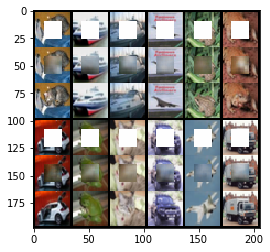

In [13]:
# After several epochs of training
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
show(make_grid(sample.cpu(), nrow=6, normalize=True))

In [14]:
# Function to lock parameters of backbone when training SSL task. 
def lock_gradients(requiresgrad=False):
    for i, (name, module) in enumerate(generator.named_children()):
        if i<5:
            for layer in module.children():
                for param in layer.parameters():
                    param.requires_grad = requiresgrad
        else:
            break
        optimizer_G = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2))
        optimizer_C = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)) # Unsure if there's any use for this

In [11]:
# Attempt at robust SSL
def apply_random_mask(img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, img_size - mask_size, 2)
        y2, x2 = y1 + mask_size, x1 + mask_size
        masked_part = img[:,:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:,:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

def training_loop(epochs, train_classifier=True, train_inpainter=True, inpainter_freq = 1):
    generator.train()
    for epoch in range(epochs):
        # Lock the shared layers after 30 epochs. 
        if epoch == 30:
            lock_gradients()
            train_inpainter=True
        for i, (imgs, labels) in enumerate(dataloader):
            if cuda:
                labels = labels.cuda()

            imgs = Variable(imgs.type(Tensor))

            if train_inpainter and i%inpainter_freq==0:
                # Create masked parts of images. 
                masked_imgs, masked_parts = apply_random_mask(imgs)

                # Configure input

                masked_imgs = Variable(masked_imgs.type(Tensor))
                masked_parts = Variable(masked_parts.type(Tensor))

                # Adversarial ground truths
                valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
                fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

                #print(masked_imgs.shape, masked_parts.shape, imgs.shape)
                # -----------------
                #  Train Generator
                # -----------------

                optimizer_G.zero_grad()

                # Generate a batch of images
                _, gen_parts = generator(masked_imgs)

                #print(gen_parts.shape)
                # Adversarial and pixelwise loss

                ## Measure the MSE between discriminator's evaluation of generator output and 8x8 matrix of 1s
                ## aka if discriminator(gen_parts) is all 1s, adversarial loss is 0 
                g_adv = adversarial_loss(discriminator(gen_parts), valid)
                g_pixel = pixelwise_loss(gen_parts, masked_parts)
                # Total loss
                g_loss = 0.001 * g_adv + 0.999 * g_pixel

                g_loss.backward()
                optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------

                optimizer_D.zero_grad()

                # Measure discriminator's ability to classify real from generated samples

                ## We want the discriminator to output all 1s on masked_parts, since that's the ground truth
                real_loss = adversarial_loss(discriminator(masked_parts), valid)
                ## We want the discriminator to output all 0s on the generated patch 
                fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
                d_loss = 0.5 * (real_loss + fake_loss)

                d_loss.backward()
                optimizer_D.step()
            if train_classifier:
                # ---------------------
                #  Train Classifier
                # ---------------------

                optimizer_C.zero_grad()

                preds, _ = generator(imgs)

                # Adversarial and pixelwise loss
                #print(preds.device, labels.device)
                c_loss = ce_loss(preds, labels)

                c_loss.backward()
                optimizer_C.step()

            # Obtain validation metrics every given number of iterations
            batches_done = epoch * len(dataloader) + i
            if batches_done % opt.sample_interval == 0:
                generator.eval()
                correct, total = 0, 0
                for j, (imgs, labels) in enumerate(testloader):
                    if cuda:
                        labels = labels.cuda()

                    imgs = Variable(imgs.type(Tensor))
                    outputs, _ = generator(imgs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    #print(predicted.shape, labels.shape, outputs.shape, images.shape)
                    correct += (predicted == labels).sum().item()
                generator.train()
                
                if train_inpainter:
                    print(
                    "[Epoch %d] [Batch %d/%d] [D loss: %f] [G adv: %f, pixel: %f] [C Loss: %f, C Acc: %f]"
                    % (epoch, i, len(dataloader), d_loss.item(), g_adv.item(), g_pixel.item(), c_loss.item(), (correct/total))
                    )
                else:
                    print('[Epoch %d] [Batch %d/%d] [C Loss: %f, C Acc: %f]' 
                          %(epoch, i, len(dataloader), c_loss.item(), (correct/total)))
                #save_sample(batches_done)
                torch.save(generator.state_dict(), 'adversarial_multigen.pth')
                torch.save(discriminator.state_dict(), 'adversarial_disc.pth')

# Train for classifier for 30 epochs, then lock parameters and train both for an additional 20-50 epochs.                 
training_loop(50, train_inpainter=False)
training_loop(30)

[Epoch 0] [Batch 0/1563] [D loss: 0.001945] [G adv: 0.981355, pixel: 0.254844] [C Loss: 0.012165, C Acc: 0.712000]
[Epoch 0] [Batch 500/1563] [D loss: 0.000094] [G adv: 0.988745, pixel: 0.270168] [C Loss: 0.052341, C Acc: 0.710000]
[Epoch 0] [Batch 1000/1563] [D loss: 0.001791] [G adv: 1.068264, pixel: 0.299227] [C Loss: 0.012641, C Acc: 0.705000]
[Epoch 0] [Batch 1500/1563] [D loss: 0.003867] [G adv: 1.161890, pixel: 0.260171] [C Loss: 0.027446, C Acc: 0.711700]
[Epoch 1] [Batch 437/1563] [D loss: 0.000200] [G adv: 1.013982, pixel: 0.298634] [C Loss: 0.081110, C Acc: 0.712800]
[Epoch 1] [Batch 937/1563] [D loss: 0.000138] [G adv: 0.994828, pixel: 0.289097] [C Loss: 0.042264, C Acc: 0.711400]
[Epoch 1] [Batch 1437/1563] [D loss: 0.000280] [G adv: 1.028802, pixel: 0.258684] [C Loss: 0.079331, C Acc: 0.709800]
[Epoch 2] [Batch 374/1563] [D loss: 0.006278] [G adv: 1.150236, pixel: 0.272160] [C Loss: 0.033923, C Acc: 0.711100]
[Epoch 2] [Batch 874/1563] [D loss: 0.000399] [G adv: 0.961432,

[Epoch 22] [Batch 614/1563] [D loss: 0.000198] [G adv: 0.973713, pixel: 0.261057] [C Loss: 0.093365, C Acc: 0.710500]
[Epoch 22] [Batch 1114/1563] [D loss: 0.000137] [G adv: 0.989092, pixel: 0.277152] [C Loss: 0.156554, C Acc: 0.707800]
[Epoch 23] [Batch 51/1563] [D loss: 0.001834] [G adv: 0.972252, pixel: 0.292759] [C Loss: 0.004068, C Acc: 0.712900]
[Epoch 23] [Batch 551/1563] [D loss: 0.000162] [G adv: 0.986805, pixel: 0.268693] [C Loss: 0.180645, C Acc: 0.711100]
[Epoch 23] [Batch 1051/1563] [D loss: 0.001638] [G adv: 0.939241, pixel: 0.260310] [C Loss: 0.039246, C Acc: 0.710900]
[Epoch 23] [Batch 1551/1563] [D loss: 0.000220] [G adv: 1.023117, pixel: 0.257279] [C Loss: 0.000676, C Acc: 0.702800]
[Epoch 24] [Batch 488/1563] [D loss: 0.000034] [G adv: 0.995551, pixel: 0.279901] [C Loss: 0.006702, C Acc: 0.703000]
[Epoch 24] [Batch 988/1563] [D loss: 0.000135] [G adv: 1.017798, pixel: 0.262062] [C Loss: 0.357682, C Acc: 0.712200]
[Epoch 24] [Batch 1488/1563] [D loss: 0.000284] [G adv

In [19]:
# From train_cifar_semisupervised_half.py
def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts,
               norm):
    max_loss = torch.zeros(y.shape[0]).cuda()
    max_delta = torch.zeros_like(X).cuda()
    for _ in range(restarts):
        delta = torch.zeros_like(X).cuda()
        if norm == "l_inf":
            delta.uniform_(-epsilon, epsilon)
        elif norm == "l_2":
            delta.normal_()
            d_flat = delta.view(delta.size(0),-1)
            n = d_flat.norm(p=2,dim=1).view(delta.size(0),1,1,1)
            r = torch.zeros_like(n).uniform_(0, 1)
            delta *= r/n*epsilon
        else:
            raise ValueError
        delta = clamp(delta, lower_limit-X, upper_limit-X)
        delta.requires_grad = True
        for _ in range(attack_iters):
            output, _ = model(normalize(X + delta))
            index = slice(None,None,None)
            if not isinstance(index, slice) and len(index) == 0:
                break
        
            loss = F.cross_entropy(output, y)
            loss.backward()
            grad = delta.grad.detach()
            d = delta[index, :, :, :]
            g = grad[index, :, :, :]
            x = X[index, :, :, :]
            if norm == "l_inf":
                d = torch.clamp(d + alpha * torch.sign(g), min=-epsilon, max=epsilon)
            elif norm == "l_2":
                g_norm = torch.norm(g.view(g.shape[0],-1),dim=1).view(-1,1,1,1)
                scaled_g = g/(g_norm + 1e-10)
                d = (d + scaled_g*alpha).view(d.size(0),-1).renorm(p=2,dim=0,maxnorm=epsilon).view_as(d)
            d = clamp(d, lower_limit - x, upper_limit - x)
            delta.data[index, :, :, :] = d
            delta.grad.zero_()
        
        temp, _ = model(normalize(X+delta))
        all_loss = F.cross_entropy(temp, y, reduction='none')
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
    return max_delta

# Idea: unlike for something like jigsaw, where we want to push outputs to something specific,
# with inpainting, we want to change input to minimize loss defined by the discriminator. 
# Therefore, standard attack_pgd, just in reverse, should be sufficient.

# Input: (Possibly) adversarially perturbed image X; hyperparameters for pgd
# Loss: adversarial_loss = torch.nn.MSELoss(), pixelwise_loss = torch.nn.L1Loss()

# Output: Delta: Perturbation to add to minimize loss on discriminator. 
# Potential issues: 
    # 1. Discriminator does not take context into account: reverse attack could result in something that does not fit context
    # 2. If the attack is bounded by L0 norm and the mask removes the attacked pixels, it's just the actual image. 
    # 3. The resulting delta might be nonzero in regions that were occluded by the mask.
        # It doesn't make sense to alter these regions since they play no role in the generator's output: reapply mask to deltas
        # Multiple runs with masks in different areas are necessary to produce meaningful deltas throughout
        # Simple fix: 4 masked images, each in a corner of image? 
    # should pixelwise loss be dropped when calculating loss for the attack, since we do not trust the image? 
    
# maybe another parameter to allow us to specify loss, since we want loss from discriminator
def reverse_attack_pgd(generator, X, y, epsilon, alpha, attack_iters, restarts, norm):
    
    max_loss = torch.zeros(X.shape[0]).cuda() # classification error?
    #max_loss = torch.zeros(1).cuda() #
    max_delta = torch.zeros_like(X).cuda() # For individual image
    max_deltas = torch.zeros_like(X).cuda() # For all four masks?
    
    index = slice(None,None,None) # not sure what this does
    # Specify 'valid' matrix.
    valid = Variable(Tensor(X.shape[0], *patch).fill_(1.0), requires_grad=False)
    
    # Specify losses:
    adversarial_loss = torch.nn.MSELoss()
    pixelwise_loss = torch.nn.L1Loss()
    
    # Build four masked images.
    mask_size = X.shape[2]//2 
    start_point = mask_size//2
    #for i, j in [(0,0), (0,mask_size), (mask_size,0), (mask_size, mask_size)]:
    for i,j in [(start_point, start_point)]:
        
        ### Unsure what dimensions of input are, or what the index stuff later is doing...
        masked_part = X[index, :, j:j+mask_size, i:i+mask_size]
        masked_img = X.clone()
        masked_img[:, j:j+mask_size, i:i+mask_size] = 1
        ###

        # Effectively identical to normal attack_pgd
        for _ in range(restarts):
            delta = torch.zeros_like(X).cuda() # Create tensor of 0s with same size as X, the input img

            # Specify norms
            if norm == "l_inf":
                delta.uniform_(-epsilon, epsilon) # Fills delta with values drawn uniformly from [-epsilon, epsilon]
            elif norm == "l_2":
                # Fills delta sampled from normal distributions with std deviation epsilon * r/n, where r is uniformly sampled
                delta.normal_()
                d_flat = delta.view(delta.size(0),-1)
                n = d_flat.norm(p=2,dim=1).view(delta.size(0),1,1,1)
                r = torch.zeros_like(n).uniform_(0, 1)
                delta *= r/n*epsilon
            else:
                raise ValueError
            

            delta = clamp(delta, lower_limit-X, upper_limit-X) # Clamp values to be within specified bounds
            
            
            delta.data[index, :, j:j+mask_size, i:i+mask_size] = 0 # Masked areas to be unaffected
            delta.requires_grad = True # torch gradient magic

            for _ in range(attack_iters):
                # bit of a nightmare keeping track of whether images have already been normalized... 
                _, gen_parts = generator(normalize(masked_img + delta))
                #print(gen_parts.shape, masked_img.shape, masked_part.shape)
                #if early_stop:
                    #index = torch.where(output.max(1)[1] == y)[0]
                #else:
                
                    #index = slice(None,None,None)
                if not isinstance(index, slice) and len(index) == 0:
                    break
                #if mixup:
                #    criterion = nn.CrossEntropyLoss()
                #    loss = mixup_criterion(criterion, model(normalize(X+delta)), y_a, y_b, lam)
                #else:
                #    loss = F.cross_entropy(output, y)
                
                g_adv = adversarial_loss(discriminator(gen_parts), valid)
                g_pixel = pixelwise_loss(gen_parts, masked_part)
                # Total loss
                g_loss = 0.001 * g_adv + 0.999 * g_pixel
                #print('Discriminator loss: %s, Pixel loss: %s, total loss: %s' %(
                #    np.round(g_adv.data.cpu().numpy(),4), np.round(g_pixel.data.cpu().numpy(),4), np.round(g_loss.data.cpu().numpy(),4)))
                g_loss.backward()
                #loss.backward()
                
                grad = delta.grad.detach()
                d = delta[index, :, :, :]
                g = grad[index, :, :, :]
                x = X[index, :, :, :]
                if norm == "l_inf":
                    d = torch.clamp(d - alpha * torch.sign(g), min=-epsilon, max=epsilon)
                elif norm == "l_2":
                    g_norm = torch.norm(g.view(g.shape[0],-1),dim=1).view(-1,1,1,1)
                    scaled_g = g/(g_norm + 1e-10)
                    d = (d - scaled_g*alpha).view(d.size(0),-1).renorm(p=2,dim=0,maxnorm=epsilon).view_as(d)
                d = clamp(d, lower_limit - x, upper_limit - x)
                delta.data[index, :, :, :] = d
                # masked area should be zero.
                delta.data[index, :, j:j+mask_size, i:i+mask_size] = 0
                delta.grad.zero_()

            #if mixup:
            #    criterion = nn.CrossEntropyLoss(reduction='none')
            #    all_loss = mixup_criterion(criterion, model(normalize(X+delta)), y_a, y_b, lam)
            #else:
            #    all_loss = F.cross_entropy(model(normalize(X+delta)), y, reduction='none')
            
            # I'm not sure what the indexing is doing...is this because it's assuming multiple images?
            _, gen_parts = generator(normalize(masked_img + delta))
            g_adv = adversarial_loss(discriminator(gen_parts), valid)
            g_pixel = pixelwise_loss(gen_parts, masked_part)
            g_loss = 0.001 * g_adv + 0.999 * g_pixel
            #print('This restart\'s final loss:', g_loss.data)
            max_delta[g_loss >= max_loss] = delta.detach()[g_loss >= max_loss]
            max_loss = torch.max(max_loss, g_loss)
            
        #max_deltas += max_delta
    #max_deltas/=4
    #return max_deltas
    return max_delta

#mu = torch.tensor(cifar10_mean).view(3,1,1).cuda()
#std = torch.tensor(cifar10_std).view(3,1,1).cuda()

#def normalize(X):
#    return (X - mu)/std

upper_limit, lower_limit = 1,0

#def clamp(X, lower_limit=0, upper_limit,1):
#    return torch.max(torch.min(X, upper_limit), lower_limit)

# just getting things to work with minimal computation
# normalization likely does not play nice with masks... 
def clamp(x,y,z):
    return x
def normalize(x):
    return x

In [16]:
# Probably should've just made this into a function to vary pgd parameters...
# Clean accuracy, adversarial accuracy, adversarial + reverse accuracy, clean + reverse accuracy
generator.eval()
correct_clean, correct_adversarial, correct_reverse, correct_reverse_jk, total = 0, 0, 0, 0, 0
for i, (imgs, labels) in enumerate(testloader):
    if cuda:
        labels = labels.cuda()

    imgs = Variable(imgs.type(Tensor))
    delta = attack_pgd(generator, imgs, labels, 8, 1, 2, 1,
               'l_2')
    delta_jk = torch.zeros_like(imgs)
    delta2 = reverse_attack_pgd(generator, imgs+delta, 420, 8, 1, 10, 1,
               'l_2')
    
    delta2_jk = reverse_attack_pgd(generator, imgs+delta_jk, 420, 8, 1, 10, 1,
               'l_2')
    
    outputs_clean, _ = generator(imgs)
    outputs_adversarial, _ = generator(imgs+delta)
    outputs_reverse, _ = generator(imgs+delta+delta2)
    outputs_reverse_jk, _ = generator(imgs+delta2_jk)
    
    _, predicted_clean = torch.max(outputs_clean.data, 1)
    _, predicted_adversarial = torch.max(outputs_adversarial.data, 1)
    _, predicted_reverse = torch.max(outputs_reverse.data, 1)
    _, predicted_reverse_jk = torch.max(outputs_reverse_jk.data, 1)
    
    total += labels.size(0)
    correct_clean += (predicted_clean == labels).sum().item()
    correct_adversarial += (predicted_adversarial == labels).sum().item()
    correct_reverse += (predicted_reverse == labels).sum().item()
    correct_reverse_jk += (predicted_reverse_jk == labels).sum().item()

print(correct_clean/total, correct_adversarial/total, correct_reverse/total, correct_reverse_jk/total)

0.7142 0.0508 0.0653 0.5591


In [17]:
generator.eval()
correct_clean, correct_adversarial, correct_reverse, correct_reverse_jk, total = 0, 0, 0, 0, 0
for i, (imgs, labels) in enumerate(testloader):
    if cuda:
        labels = labels.cuda()

    imgs = Variable(imgs.type(Tensor))
    delta = attack_pgd(generator, imgs, labels, 8, 1, 1, 1,
               'l_2')
    delta_jk = torch.zeros_like(imgs)
    delta2 = reverse_attack_pgd(generator, imgs+delta, 420, 8, 1, 10, 1,
               'l_2')
    
    delta2_jk = reverse_attack_pgd(generator, imgs+delta_jk, 420, 8, 1, 10, 1,
               'l_2')
    
    outputs_clean, _ = generator(imgs)
    outputs_adversarial, _ = generator(imgs+delta)
    outputs_reverse, _ = generator(imgs+delta+delta2)
    outputs_reverse_jk, _ = generator(imgs+delta2_jk)
    
    _, predicted_clean = torch.max(outputs_clean.data, 1)
    _, predicted_adversarial = torch.max(outputs_adversarial.data, 1)
    _, predicted_reverse = torch.max(outputs_reverse.data, 1)
    _, predicted_reverse_jk = torch.max(outputs_reverse_jk.data, 1)
    
    total += labels.size(0)
    #print(predicted.shape, labels.shape, outputs.shape, images.shape)
    #print(predicted_clean.shape, labels.shape, imgs.shape, outputs_clean.shape)
    correct_clean += (predicted_clean == labels).sum().item()
    correct_adversarial += (predicted_adversarial == labels).sum().item()
    correct_reverse += (predicted_reverse == labels).sum().item()
    correct_reverse_jk += (predicted_reverse_jk == labels).sum().item()

print(correct_clean/total, correct_adversarial/total, correct_reverse/total, correct_reverse_jk/total)

0.7142 0.1072 0.1735 0.5513


In [ ]:
# TL;DR: 

# Original inpainting task image size is 128x128 (experiments with CIFAR-10 use 32x32):
# For training, randomly select a 64x64 mask to cut out from each image
# Note: Discriminator output is 8x8: side length is input length/2^3, since we have 3 conv layers of stride 2. 
    # Trained such that true images should be close to 8x8 of 1s (0s for fake images)
    # Final output layer is just a conv layer, so nothing explicitly ensuring [0,1] is a suitable range?

# Training loop:
    # Send image through generator: output is 64x64 mask.
    # Calculate generator loss using adversarial loss(MSE with output of discriminator) and pixelwise loss
    
    # Send mask through discriminator: output is 8x8 patch
    # Note: Only the mask, without other context, is sent into the discriminator. This is from the paper.
    # Calculate discriminator loss: feed in mask from generator, MSE with patch of 8x8 patch of 1s
        # Average with ground-truth mask, MSE with 8x8 patch of 0s
    
# aka discriminator only tells us whether the generated mask looks legit on its own
# the pixelwise loss is what keeps the generator from generating the same mask for every image
# (because discriminator doesn't care about context)